In [1]:
from own_functions import *
import MetaTrader5 as mt
import pandas as pd
import plotly.express as px
import matplotlib.pylab as plt
import numpy as np
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import talib
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier

from talipp.indicators import EMA, SMA, Stoch, DPO
from talipp.ohlcv import OHLCVFactory

In [2]:
mt.initialize()
login= 51505377
password="7JhZp8Vj"
server="ICMarketsSC-Demo"
mt.login(login,password,server)

True

In [3]:
symbol="GBPUSD"
timeframe=mt.TIMEFRAME_D1

#ohcl data
ohlc_data=pd.DataFrame(mt.copy_rates_range(symbol,timeframe,datetime(2021,1,1),datetime.now()))
df=pd.DataFrame(ohlc_data)[['time','open','high','low','close']]

df_temp=pd.DataFrame(ohlc_data)[['time','open','high','low','close']]

df['WILLR_15']=talib.WILLR(df['high'],df['low'],df['close'],timeperiod=15) #Williams' %R
df['WILLR_15']=df['WILLR_15'].shift(periods=1)
df['WILLR_23']=talib.WILLR(df['high'],df['low'],df['close'],timeperiod=23) #Williams' %R
df['WILLR_23']=df['WILLR_23'].shift(periods=1)
df['WILLR_42']=talib.WILLR(df['high'],df['low'],df['close'],timeperiod=42) #Williams' %R
df['WILLR_42']=df['WILLR_42'].shift(periods=1)
df['WILLR_145']=talib.WILLR(df['high'],df['low'],df['close'],timeperiod=145) #Williams' %R
df['WILLR_145']=df['WILLR_145'].shift(periods=1)

df['b_flag'] = 0
df['s_flag'] = 0

df=df.dropna()
df=df.reset_index(drop=True)

In [4]:
label_data(df,[1],[2],80,symbol,False)

In [5]:
df=df.drop(columns=['time','high','low','close','open'])

df=df.dropna()
df=df.reset_index(drop=True)

X=df.iloc[:,0:len(df.columns)-2].values
y=df.iloc[:,len(df.columns)-2].values        #Buy
#y=df.iloc[:,len(df.columns)-1].values       #Sell

X2=df.iloc[:,0:len(df.columns)-2]

#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=0, shuffle=False)

from sklearn.model_selection import TimeSeriesSplit
# Annahme: Die Daten sind nach Zeit sortiert
tscv = TimeSeriesSplit(n_splits=5)  # Hier können Sie die Anzahl der Splits anpassen

print(tscv)

for train_index, test_index in tscv.split(df):
    train_data, test_data = df.iloc[train_index], df.iloc[test_index]
    
    x_train = train_data.iloc[:, 0:len(df.columns)-2].values
    y_train = train_data.iloc[:, len(df.columns)-2].values

    x_test = test_data.iloc[:, 0:len(df.columns)-2].values
    y_test = test_data.iloc[:, len(df.columns)-2].values

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)


In [6]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
fig1=px.line(x_train,x=0,y=[1])
fig1.show()
x_train=sc.fit_transform(x_train)
fig2=px.line(x_train,x=0,y=[1])
fig2.show()
x_test=sc.fit_transform(x_test)
X=sc.fit_transform(X)

Optimal number of features: 4
Best features: Index(['WILLR_15', 'WILLR_23', 'WILLR_42', 'WILLR_145'], dtype='object')


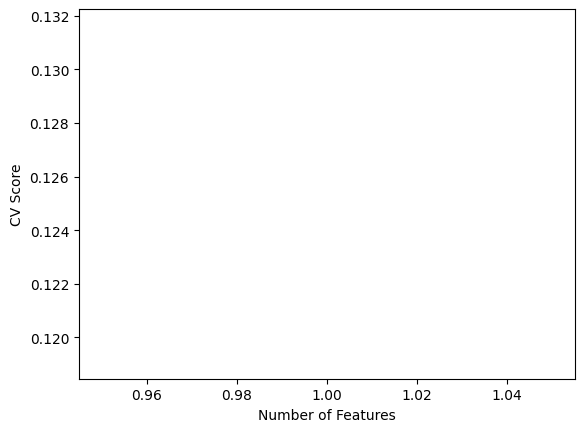

[[83 21]
 [ 0  0]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89       104
           1       0.00      0.00      0.00         0

    accuracy                           0.80       104
   macro avg       0.50      0.40      0.44       104
weighted avg       1.00      0.80      0.89       104

0.0
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': {0: 5, 1: 6}, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 80, 'n_jobs': None, 'oob_score': False, 'random_state': 5, 'verbose': 0, 'warm_start': False}
[0.22677496 0.21959962 0.25250448 0.30112093]


In [7]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Your data (assuming X2, x_train, and x_test are defined)

mF = 4

# Create the RFECV model
rfecv = RFECV(
    estimator=RandomForestClassifier(random_state=5, n_estimators=80, class_weight={0: 5, 1: 6}),
    min_features_to_select=mF,
    step=1,
    cv=5,
    scoring='precision',
    n_jobs=-1,
    verbose=0
)

# Fit the RFECV model
rfecv = rfecv.fit(x_train, y_train)

# Print results
print('Optimal number of features:', rfecv.n_features_)
print('Best features:', X2.columns[rfecv.support_])
X2.drop(X2.columns[~rfecv.support_], axis=1, inplace=True)

# Plot the cross-validation scores
plt.figure()
plt.xlabel("Number of Features")
plt.ylabel("CV Score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()


# Transform the training and test sets based on selected features
x_train = rfecv.transform(x_train)
x_test = rfecv.transform(x_test)

# Create a new RandomForestClassifier with the same parameters
RF_model = RandomForestClassifier(random_state=5, n_estimators=80, class_weight={0: 5, 1: 6})

# Fit the model on the transformed training data
RF_rfecv_model = RF_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = RF_rfecv_model.predict(x_test)

# Print evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, precision_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(precision_score(y_test, y_pred))

# Get the parameters and feature importances
print(RF_rfecv_model.get_params())
print(RF_rfecv_model.feature_importances_)


In [8]:
grid=GridSearchCV(
    estimator=RandomForestClassifier(random_state=5, n_estimators= 80,class_weight= {0:5,1:6}, max_features=None),
    #param_grid={'class_weight': [{0:5,1:v} for v in range(5,20,1)]},
    #param_grid={'class_weight': [{0:5,1:6}]},
    #param_grid={'n_estimators': [50,60,70,80,90,100,110,120,130,140,150]},
    param_grid={'n_estimators': [80]},
    #param_grid={'random_state': [1,2,3,4,5,6,7,8,9,10]},
    #param_grid={'max_features': ['auto']},
    scoring={'precision':make_scorer(precision_score)},
    #scoring={'balanced_accuracy_score':make_scorer(balanced_accuracy_score)},
    refit='precision',
    #return_train_score=True,
    #cv=22,
    n_jobs=-1
)
grid.fit(x_train,y_train)
grid.n_features_in_

4

In [9]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(pd.DataFrame(grid.cv_results_))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,split3_test_precision,split4_test_precision,mean_test_precision,std_test_precision,rank_test_precision
0,0.230349,0.009715,0.004103,0.000799,80,{'n_estimators': 80},0.0,0.076923,0.060606,0.205882,0.284091,0.1255,0.103859,1


In [10]:
y_pred=grid.predict(x_test)
print(len(x_test))

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))
print(precision_score(y_test,y_pred))

104
[[77 27]
 [ 0  0]]
              precision    recall  f1-score   support

           0       1.00      0.74      0.85       104
           1       0.00      0.00      0.00         0

    accuracy                           0.74       104
   macro avg       0.50      0.37      0.43       104
weighted avg       1.00      0.74      0.85       104

0.0


In [11]:
import joblib
joblib.dump(grid,r'Models\\model_' + symbol + '.joblib')

['Data\\\\model_GBPUSD.joblib']